### Classifying students's answers

#### Import libraries

In [1]:
# Input
# from db import PythonProblems
import io

#DB
from questions.models import Solution, Cluster, UserLog
import psycopg2

# Helpers
import numpy as np
import pickle
import base64
import pandas as pd

# Preprocessing
import tokenize
from sklearn.feature_extraction.text import CountVectorizer

# Distance
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, pairwise_kernels

# Learning
from clustering import Clustering
from questions.sampling import get_next_sample
from analyzer import python_analyzer

# Visualization
from plot2d import Plot2D
import matplotlib.pyplot as plt
import seaborn as sns
from generate_pdf import PDFReport
import pyLDAvis.sklearn


%matplotlib inline

In [2]:
## Cleaning database
last_id = 132
problems = Problem.objects.filter(id__gt=last_id)
solutions_obj = Solution.objects.filter(problem__in=problems).update(ignore=True)
print("Problems to be ignored: %d" % problems.count())

problems = Problem.objects.filter(id__lte=last_id)
# problems = Problem.objects.all()
print("Problems to be used: %d" % problems.count())

solutions_obj = Solution.objects.filter(problem__in=problems, ignore=False).order_by('id')
# solutions_obj = Solution.objects.all().order_by('id')
print("Solutions to be used: %d" % solutions_obj.count())

docs_id = []
questions = []
solutions = []

# Fill separated structures
for sol in solutions_obj:
    docs_id.append(sol.id)
    questions.append(sol.problem.content)
    solutions.append(sol.content)

print("Got %d documents" %(solutions_obj.count()))

Problems to be ignored: 591
Problems to be used: 132
Solutions to be used: 54
Got 54 documents


***Limitações do parser:***

***1. Variável e nome reservado são do mesmo tipo. Não consigo separar sem fazer uma pré-lista. Mas pode ser o critério para ajustar o CountVectorizer***

***2. Não é possível processar solução sintaticamente errada. Talvez uma tokenização básica possa ajudar quando esse for o caso e já é uma indicação de que está errado.***

### Preprocessing solutions into bag of words ###

In [3]:
def create_bag_of_words(docs, vectorizer_method, binary=False, min_df=0.2):
    vectorizer = vectorizer_method(analyzer = python_analyzer,
                                   binary=binary,
                                   min_df=min_df) 
    train_data_features = vectorizer.fit_transform(docs)
    try:
        train_data_features = train_data_features.toarray()
    # It's already an array
    except AttributeError:
        pass
    return train_data_features, vectorizer, vectorizer.get_feature_names()

In [4]:
# %load vectorizer.py
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from analyzer import python_analyzer
import numpy as np


class NCutVectorizer(object):
    def __init__(self, analyzer, binary, min_df):
        self.vectorizer = CountVectorizer(analyzer = python_analyzer,
                                          binary=binary,
                                          min_df=min_df)

    def fit_transform(self, docs):
        train_data_features = self.vectorizer.fit_transform(docs)
        train_data_features = train_data_features.toarray()

        # Calculate NCut-weight
        doc_mat_norm = normalize(train_data_features)
        S = np.dot(doc_mat_norm.T, doc_mat_norm) + 0.001
        D = np.power(np.sum(S, axis=1), -0.5) * np.eye(S.shape[0])
        Y = np.dot(D, train_data_features.T)
        return Y.T
    
    def get_feature_names(self):
        return self.vectorizer.get_feature_names()

    def transform(object):
        train_data_features = self.vectorizer.transform(docs)
        train_data_features = train_data_features.toarray()
        

# Connect to DB

In [5]:
connection = psycopg2.connect(user = "machineteaching",
                                  password = "***REMOVED***",
                                  host = "localhost",
#                                   port = "5432",
                                  database = "machineteaching")
connection.autocommit=True
cursor = connection.cursor()

In [13]:
def get_where_items(exp_id):
    cols = ["vectorizer", "min_df", "is_binary", "distance", "method", "dataset", "k", "model", "X"]
    query = "SELECT %s from experiments_solution where experiment_id = %s" % (", ".join(cols), exp_id) 
    cursor.execute(query)
    where_items = cursor.fetchall()
    return where_items

def analyze(solutions, where_items, exp_id):
    v = eval(where_items[0][0])
    m = where_items[0][1]
    b = where_items[0][2]
    dist = where_items[0][3]
    method = where_items[0][4]
    k = where_items[0][6]
    model_db = pickle.loads(base64.b64decode(where_items[0][7]))
    X = np.asarray(where_items[0][8])

    train_data_features, vectorizer, feature_names = create_bag_of_words(solutions, v, binary=b, min_df=m)
    clustering = Clustering(train_data_features, k, metric=dist)
    clustering.seed = model_db.random_state
    
    model, document_topic, word_topic = getattr(clustering, method)()
    
#     savefig='problems_20190101_%s_%s_exp_%s_%s_document_topic_distribution' % (method, clustering.seed, 
#                                                                                    exp_id, clustering.k)
#     clustering.plot_topic_distribution(title="Document distribution per topic", ylabel="Document ID", savefig=savefig)

#     print("Count per class:")
#     clusters = clustering.document_topic.argmax(axis=1)
#     counts = np.unique(clusters, return_counts=True)
#     print(counts)
    return model, vectorizer

def transform(student, solutions, model_db, vectorizer, exp_id):
    train_data_features_student = vectorizer.transform([student]).toarray()
    train_data_features_solutions = vectorizer.transform(solutions_problem).toarray()
    
    X = np.concatenate((train_data_features_student, train_data_features_solutions), axis=0)

    y_student = model_db.transform(train_data_features_student)
    y_solutions = model_db.transform(train_data_features_solutions)
    return X, y_student, y_solutions
#     print("Count per class:")
#     clusters = clustering.document_topic.argmax(axis=1)
#     counts = np.unique(clusters, return_counts=True)
#     print(counts)
#     return clustering, method, feature_names, model

In [7]:
import random

In [48]:
student = random.choice(User.objects.all())
# student = User.objects.get(email='lmoraes@cos.ufrj.br')
student

<User: lucarocha95@gmail.com>

In [141]:
exercises = UserLog.objects.filter(user=student, outcome__in=['P', 'F']).order_by('timestamp')
exercises

<QuerySet [<UserLog: UserLog object (3734)>, <UserLog: UserLog object (3735)>, <UserLog: UserLog object (3736)>, <UserLog: UserLog object (3737)>, <UserLog: UserLog object (3738)>, <UserLog: UserLog object (3740)>, <UserLog: UserLog object (3741)>, <UserLog: UserLog object (3742)>, <UserLog: UserLog object (3743)>, <UserLog: UserLog object (3744)>]>

In [56]:
exercise = exercises[0]
student_solution = exercise.solution
print(student_solution)
solutions_problem = Solution.objects.filter(problem=exercise.problem, ignore=False).values_list('content', flat=True)

for item in solutions_problem:
    print(item)

# Complete your function using this header
def digit_sum(digit):
    a = str(digit)
    aa = int(a*2)
    aaa = int(a*3)
    aaaa = int(a*4)
    soma = digit + aa + aaa + aaaa
    return soma
# Complete your function using this header
def digit_sum(digit):
    total = 0
    for i in range(1,5):
        number = "%s" % digit
        number = int(number * i)
        total = total + number
    return total
def digit_sum(digit):
    n1 = int("{0}".format(digit))
    n2 = int("{0}{1}".format(digit,digit))
    n3 = int("{0}{1}{2}".format(digit,digit,digit))
    n4 = int("{0}{1}{2}{3}".format(digit,digit,digit,digit))
    total = n1+n2+n3+n4
    return total


# Experiment 1463

- Min DF: 0.35
- Binary: True
- Vectorizer: NCut
- Method: NMF
- Best k: 7

In [66]:
# Get experiment conditions
exp_id = 1463
where_items = get_where_items(exp_id)
print("Conditions")
print(where_items[0][0:7])

model_db = pickle.loads(base64.b64decode(where_items[0][7]))
model, vectorizer  = analyze(solutions, where_items, exp_id)
y_student, y_solutions = transform(student_solution, solutions, model_db, vectorizer, exp_id)



Conditions
('NCutVectorizer', 0.35, True, 'euclidean', 'nmf', 'solution_all', 7)


/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator NMF from version 0.20.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


AttributeError: 'NCutVectorizer' object has no attribute 'transform'

# Experiment 26

- Min DF: 0.05
- Binary: True
- Vectorizer: Count
- Method: LDA
- Best k: 12

In [57]:
# Get experiment conditions
exp_id = 26
where_items = get_where_items(exp_id)
print("Conditions")
print(where_items[0][0:7])

model_db = pickle.loads(base64.b64decode(where_items[0][7]))
model_db.n_jobs = 1
model, vectorizer = analyze(solutions, where_items, exp_id)

X, y_student, y_solutions = transform(student_solution, solutions_problem, model_db, vectorizer, exp_id)

c = Clustering(X, where_items[0][6])
c.document_topic = np.concatenate((y_student, y_solutions), axis=0)
# c.plot_topic_distribution()
print(np.array([xi * 100//1 for xi in c.document_topic]))

X, y_student, y_solutions = transform(student_solution, solutions_problem, model, vectorizer, exp_id)
c = Clustering(X, where_items[0][6])
c.document_topic = np.concatenate((y_student, y_solutions), axis=0)
print(np.array([xi * 100//1 for xi in c.document_topic]))
# c.plot_topic_distribution()


Conditions
('CountVectorizer', 0.05, True, 'euclidean', 'lda', 'solution_all', 12)
[[11.  0.  0.  0.  0. 82.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 98.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 95.]]
[[11.  0.  0.  0.  0. 82.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 98.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 95.]]


/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LatentDirichletAllocation from version 0.20.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [168]:
# Constants
# Initial learning state
L0 = 0
# Probability of transition
T = 0.3
# Probability of slip
S = 0.1
# Probability of guess
G = 0.3

In [169]:
def correct(learning_state):
    learning_correct = learning_state * (1 - S)
    guess_correct = ((1 - learning_state) * G)
    learning_evidence = learning_correct/(learning_correct + guess_correct)
    return learning_evidence

def incorrect(learning_state):
    learning_incorrect = learning_state * S
    guess_incorrect = ((1 - learning_state) * (1 - G))
    learning_evidence = learning_incorrect/(learning_incorrect + guess_incorrect)
    return learning_evidence
    
def update(learning_state, iscorrect=True):
    if iscorrect:
        learning_evidence = correct(learning_state)
    else:
        learning_evidence = incorrect(learning_state)
    print("Learning evidence: %s" % learning_evidence)
    learning_state = learning_evidence + ((1 - learning_evidence) * T)
    return learning_state

In [170]:
l = 0

In [180]:
l = update(l, False)
print(l)

Learning evidence: 0.07142853069780523
0.3499999714884637


# Experiment 24

- Min DF: 0.05
- Binary: True
- Vectorizer: Count
- Method: NMF
- Best k: 15

Conditions
('CountVectorizer', 0.05, True, 'euclidean', 'nmf', 'solution_all', 15)


/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator NMF from version 0.20.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


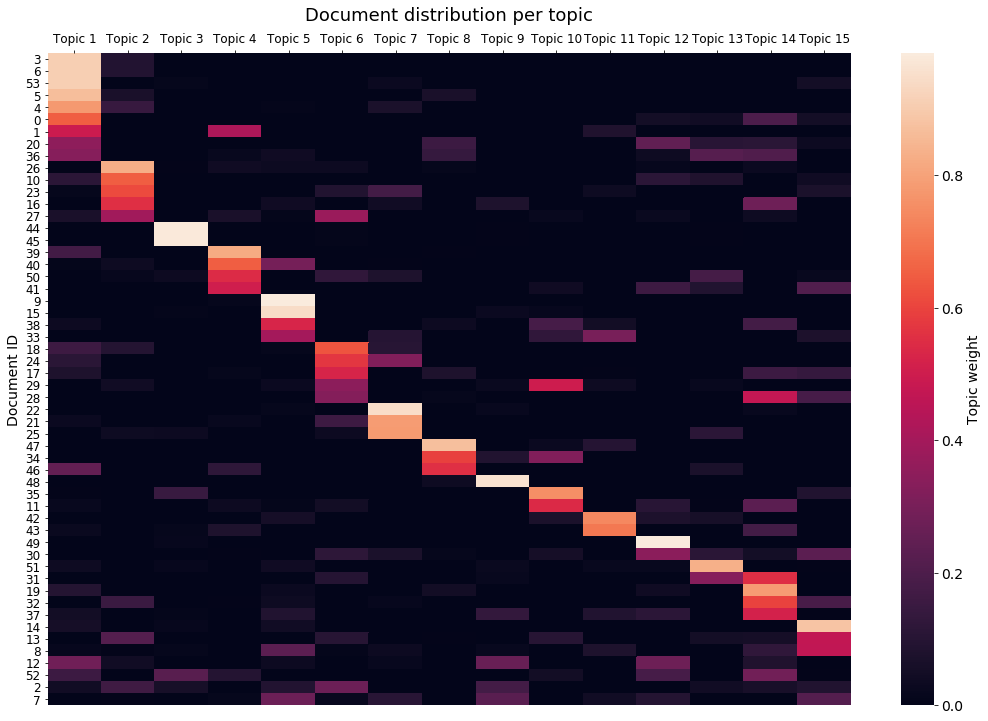

Count per class:
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), array([10,  5,  2,  4,  5,  4,  3,  3,  1,  3,  2,  2,  1,  6,  3]))


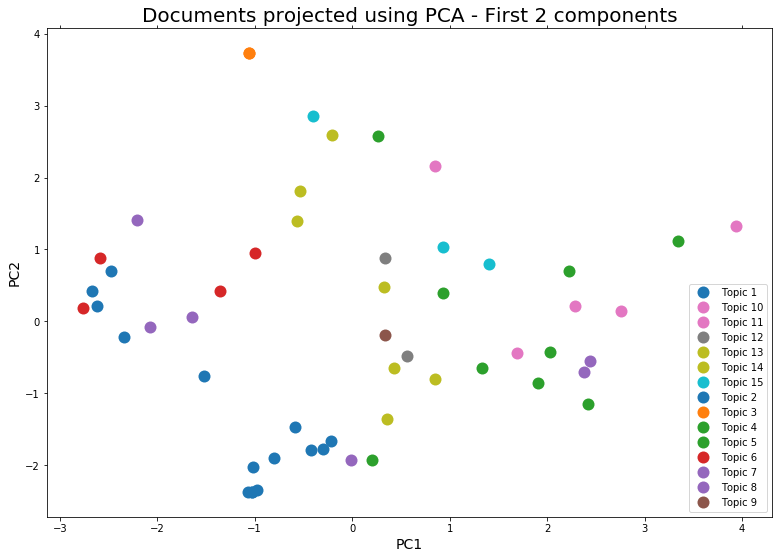

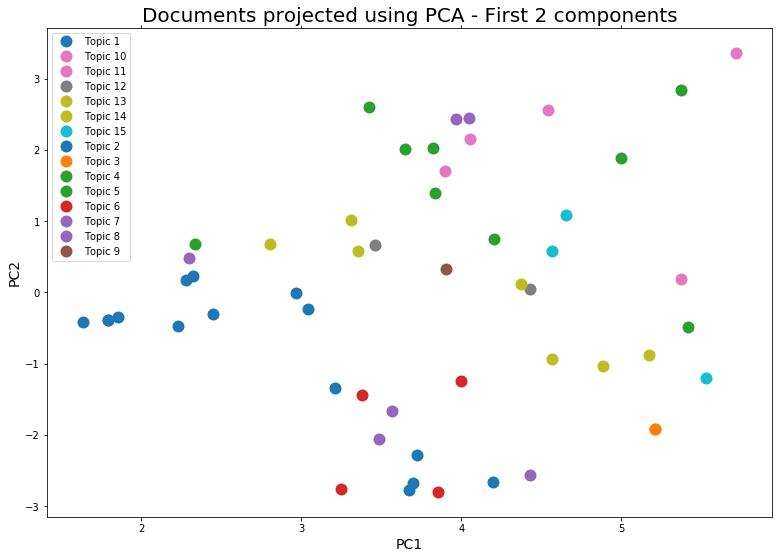

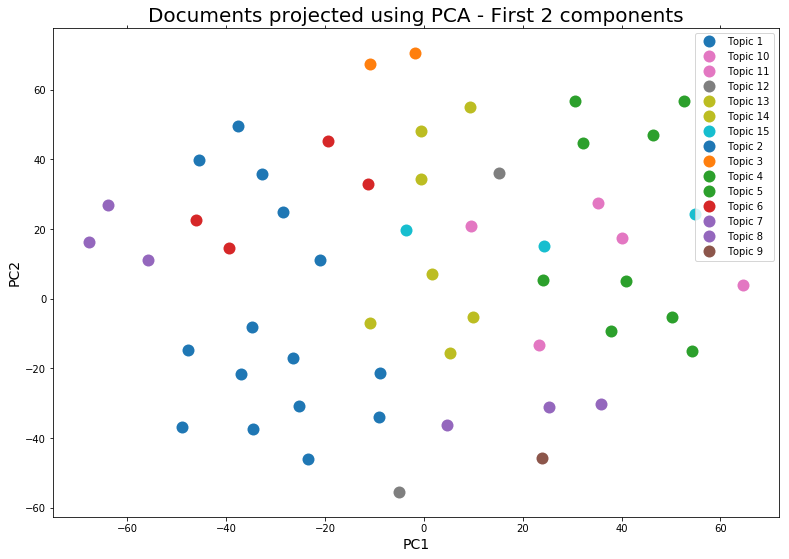

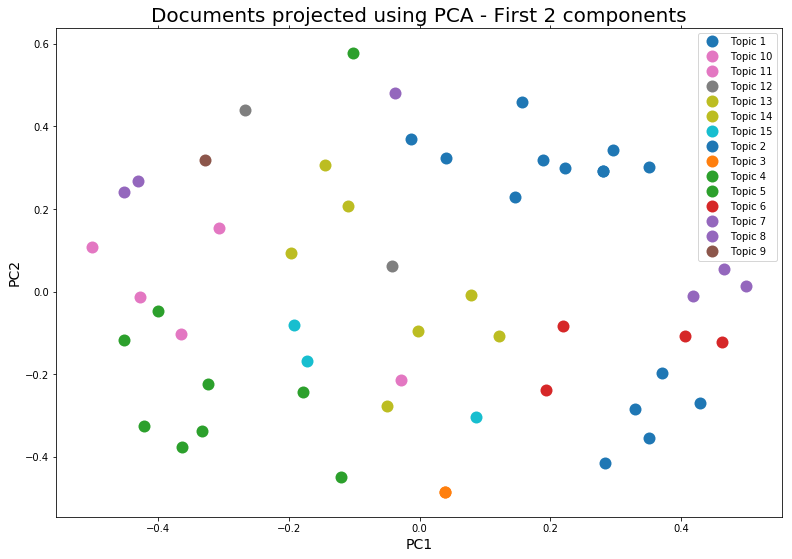

(54, 15)
(54, 54)


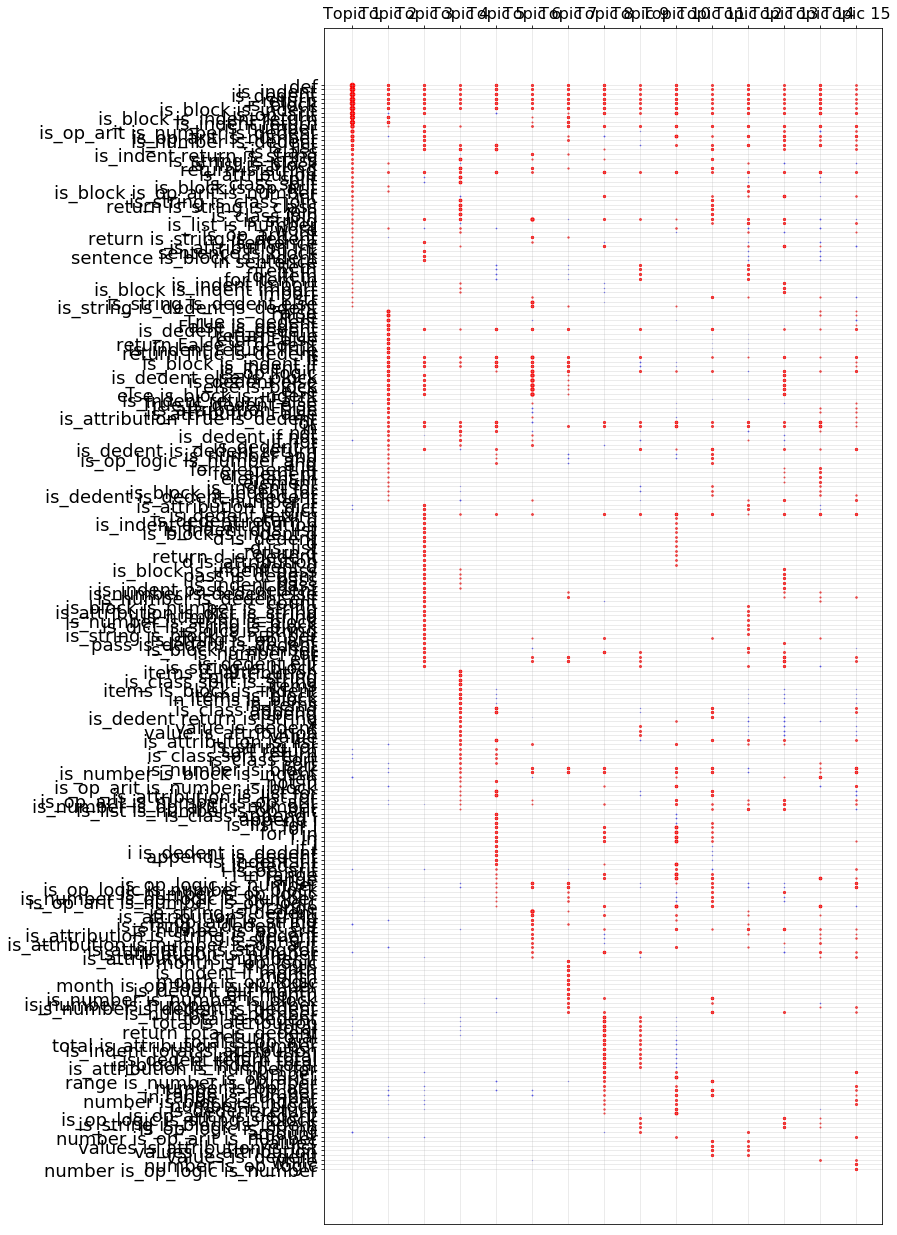

Topic #0: return, is_indent, is_dedent, def, is_block is_indent, is_block, is_op_arit, is_block is_indent return, is_indent return, is_number
Topic #1: False, True, True is_dedent, False is_dedent, is_dedent is_dedent, return True is_dedent, return False, return False is_dedent, return True, is_indent return True
Topic #2: sentence is_block is_indent, sentence is_block, in sentence, is_dict, is_attribution is_dict, sentence, is_list, is_dedent return, is_class, is_op_arit is_number is_dedent
Topic #3: is_class split, split, is_class join, is_string is_class join, join, return is_string is_class, is_string is_class, return is_string, is_class split is_string, split is_string
Topic #4: is_list for, is_attribution is_list for, is_attribution is_list, is_class append, append, is_indent if, is_block is_indent if, is_class, is_list, for
Topic #5: is_string is_dedent, else, is_dedent else is_block, else is_block is_indent, else is_block, is_dedent else, is_string, if, is_op_logic, is_string i

/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_ter

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
0      6.674680        1       1  0.031915  0.053358
1      7.639325        1       2  0.236477 -0.071601
2      7.840320        1       3  0.099138  0.172218
3      7.363359        1       4 -0.030278 -0.128014
4      8.213712        1       5 -0.090945 -0.183233
5      7.581845        1       6  0.217787 -0.048039
6      7.095033        1       7  0.182521 -0.102864
7      4.715548        1       8 -0.226287  0.047919
8      3.910237        1       9 -0.051426  0.144247
9      6.410015        1      10 -0.197340 -0.011566
10     6.043423        1      11 -0.136357 -0.163920
11     5.185293        1      12 -0.052469  0.180823
12     5.400781        1      13  0.091128  0.121343
13     8.200666        1      14 -0.048379  0.059495
14     7.725765        1      15 -0.025486 -0.070166, topic_info=Empty DataFrame
Columns: [Category, Freq, Term, Total, loglift, logprob]
Index: [], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=0, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

In [15]:
# Get experiment conditions
exp_id = 24
where_items = get_where_items(exp_id)
print("Conditions")
print(where_items[0][0:7])

clustering, method, feature_names, model = analyze(solutions, where_items, exp_id)
sample, y = plot_reduction(clustering, method, exp_id)
pdf(sample, y, clustering, method, exp_id)
plot_words_per_topic(clustering, feature_names, exp_id, size=10, figsize=(10,22))
# plot_words_per_topic(clustering, feature_names, exp_id, size=10, figsize=(10,60), topics=[2,5,7,9,11], cutoff=True)
print_top_words(clustering.model, feature_names, 10)
panel = LDAvis(solutions, where_items, model)
panel